In [1]:
from datetime import datetime, timedelta
import gnss_tools.orbits as orbits
import gnss_tools.time as time
import gnss_tools.coords as coords
import utils

In [2]:
import os
# Create local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)

In [3]:
import numpy as np
from datetime import datetime, timedelta
import gnss_tools.orbits as orbits
import gnss_tools.time as time
sim_start_dt = datetime(2024, 5, 10)
sim_end_dt = sim_start_dt + timedelta(days=1)
sim_start_gpst = time.convert_datetime_to_gps_seconds(sim_start_dt)
sim_end_gpst = time.convert_datetime_to_gps_seconds(sim_end_dt)
sim_interval = 1  # seconds
geom_epochs_gpst = np.arange(sim_start_gpst, sim_end_gpst, sim_interval)
sp3_arrays = orbits.download_and_parse_sp3_data(sim_start_gpst, sim_end_gpst, data_dir, True)
sat_id = "G01"
sat_pos_ecf = sp3_arrays.position[sat_id]
rx_pos_ecf = np.array([-4239199.3, -2447502.8, 4079913.9])  # ECEF coordinates of Rx in meters
sat_pos_interp_ecf = orbits.compute_array_lagrange_interpolation(
    geom_epochs_gpst - sim_start_gpst, sp3_arrays.epochs - sim_start_gpst, sat_pos_ecf, 5
)
geometric_range = np.linalg.norm(sat_pos_interp_ecf - rx_pos_ecf[None, :], axis=1)  # in meters
speed_of_light = 299792458.0  # in meters per second
propagation_delay = geometric_range / speed_of_light  # in seconds

In [5]:
import numpy as np

sim_duration = 60.0
geom_sim_rate = 1.0
num_geom_epochs = int(sim_duration / geom_sim_rate)
geom_sim_epochs = np.arange(num_geom_epochs) / geom_sim_rate
rx_clock_initial_error = 0.0 # in seconds
rx_clock_drift = 1e-7 # in seconds per second
rx_clock_error = rx_clock_initial_error + rx_clock_drift * geom_sim_epochs
tx_clock_error = ... # interpolate from realistic satellite clock data (SP3?)


In [6]:
sim_duration = 60.0

geom_sim_rate = 1.0
num_geom_epochs = int(sim_duration * geom_sim_rate)
geom_sim_epochs = np.arange(num_geom_epochs) / geom_sim_rate
rx_clock_drift = 1e-7  # in seconds per second
rx_clock_error = rx_clock_drift * geom_sim_epochs  # in seconds

tx_clock_error = ... # interpolate from realistic satellite clock data (SP3?)

In [7]:
import numpy as np
from datetime import datetime, timedelta
import gnss_tools.orbits as orbits
import gnss_tools.time as time
sim_start_gpst = ...
# Get satellite positions from SP3 data
data_dir = ...  # path to local data directory
sp3_arrays = orbits.download_and_parse_sp3_data(sim_start_gpst, sim_start_gpst + sim_duration, data_dir, True)
sat_id = "G01"
sat_pos_ecf = orbits.compute_array_lagrange_interpolation(
    geom_sim_epochs, sp3_arrays.epochs - sim_start_gpst, sp3_arrays.position[sat_id], 5
)
# Simulate static receiver position
rx_pos_ecf = np.array([-4239199.3, -2447502.8, 4079913.9])  # ECEF coordinates of Rx in meters
# Calculate geometric range and propagation delay
geometric_range = np.linalg.norm(sat_pos_ecf - rx_pos_ecf[None, :], axis=1)  # in meters
propagation_delay = geometric_range / 299792458.0  # in seconds

TypeError: unsupported operand type(s) for +: 'ellipsis' and 'float'

In [ ]:
# only simulate 2 seconds;  2MHz is a lot of samples!
samp_rate = 2e6
num_samples = int(sim_duration * samp_rate)
samp_times = np.arange(num_samples) / samp_rate
# calculate propagation delay tau(t)
tau_interp = np.interp(samp_times - rx_clock_error, geom_sim_epochs, propagation_delay)
tx_clock_error_at_transmit_time = np.interp(samp_times - rx_clock_error - tau_interp, geom_sim_epochs, tx_clock_error)

code_phase_chips = tx_clock_error_at_transmit_time * 1.023e6  # in chips
signal_arr = np.exp(1j * phi) * (
    ca_code_seq[(code_phase_chips).astype(int) % ca_code_length]
)

In [ ]:
sat_clock_error = np.array([])
zero_code_phase_gpst = 0
rx_clock_error = np.array([])

# simulate 5 seconds;  2MHz is a lot of samples!
samp_rate = 2e6
num_samples = int(5.0 * samp_rate)
# Generate our t_k, offset to be zero at start of simulation
sim_epochs = np.arange(num_samples) / samp_rate  # zero at start of simulation
# Calculate tau(t)
tau_interp = np.interp(sim_epochs, geom_epochs_gpst - sim_start_gpst, propagation_delay)
# Calculate Delta t_tx(t - tau(t))
sat_clock_error_at_transmit_time = np.interp(sim_epochs - tau_interp, geom_epochs_gpst - sim_start_gpst, sat_clock_error)
# Calculate code phase: t_tx(t-tau(t)) = t + Delta t_tx(t - tau(t))
code_phase = sim_epochs + sat_clock_error_at_transmit_time
# Calculate carrier phase
rx_clock_error = np.interp(sim_epochs, geom_epochs_gpst - sim_start_gpst, rx_clock_error)

In [8]:
sim_start_dt = datetime(2024, 5, 10)
sim_end_dt = sim_start_dt + timedelta(days=1)
sim_start_gpst = time.convert_datetime_to_gps_seconds(sim_start_dt)
sim_end_gpst = time.convert_datetime_to_gps_seconds(sim_end_dt)

sp3_arrays = orbits.download_and_parse_sp3_data(sim_start_gpst, sim_end_gpst, data_dir, True)
assert sp3_arrays is not None, "Failed to download SP3 data"

TypeError: expected str, bytes or os.PathLike object, not ellipsis

In [ ]:
sp3_arrays.clock.keys()

Text(0.5, 1.0, 'SP3 Estimated Satellite Clocks (Offset to start at 0): 2024-05-10 to 2024-05-11')

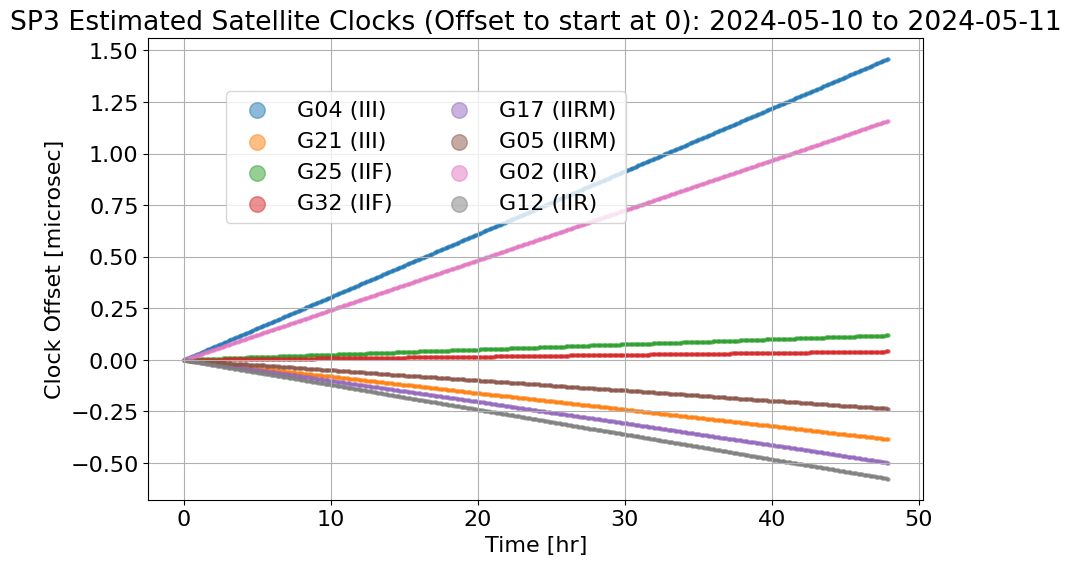

In [4]:
# Plot satellite clocks
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import scipy.signal
import gnss_tools.misc.nan_utils as nan_utils


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_epoch_offset_gpst = sim_start_gpst
plot_times = sp3_arrays.epochs - plot_epoch_offset_gpst

prn_examples = {
    "III": [4, 21],
    "IIF": [25, 32],
    "IIRM": [17, 5],
    "IIR": [2, 12]
}
# for sat_id, sat_clock in sp3_arrays.clock.items():
#     if not sat_id.startswith("G"):
#         continue
#     prn = int(sat_id[1:])
#     block_key = None
#     for key, prn_list in prn_examples.items():
#         if prn in prn_list:
#             block_key = key
#             break
#     if block_key is None:
#         continue
for block_key, prn_list in prn_examples.items():
    for prn in prn_list:
        sat_id = f"G{prn:02}"
        sat_clock = sp3_arrays.clock.get(sat_id, None)
        if sat_clock is None:
            continue
        # ax.plot(plot_times / 3600.0, nan_utils.nan_scipy_detrend(sat_clock), marker=".", markersize=5, alpha=.1, label=f"G{prn:02} ({block_key})")
        ax.scatter(plot_times / 3600.0, sat_clock - sat_clock[0], s=5, alpha=.5, label=f"G{prn:02} ({block_key})")
ax.grid()
ax.legend(loc=(.1, .6), ncol=2, markerscale=5)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Clock Offset [microsec]")
ax.set_title(f"SP3 Estimated Satellite Clocks (Offset to start at 0): {sim_start_dt:%Y-%m-%d} to {sim_end_dt:%Y-%m-%d}")

Text(0.5, 1.0, 'SP3 Estimated Satellite Clocks (Detrended): 2024-05-10 to 2024-05-11')

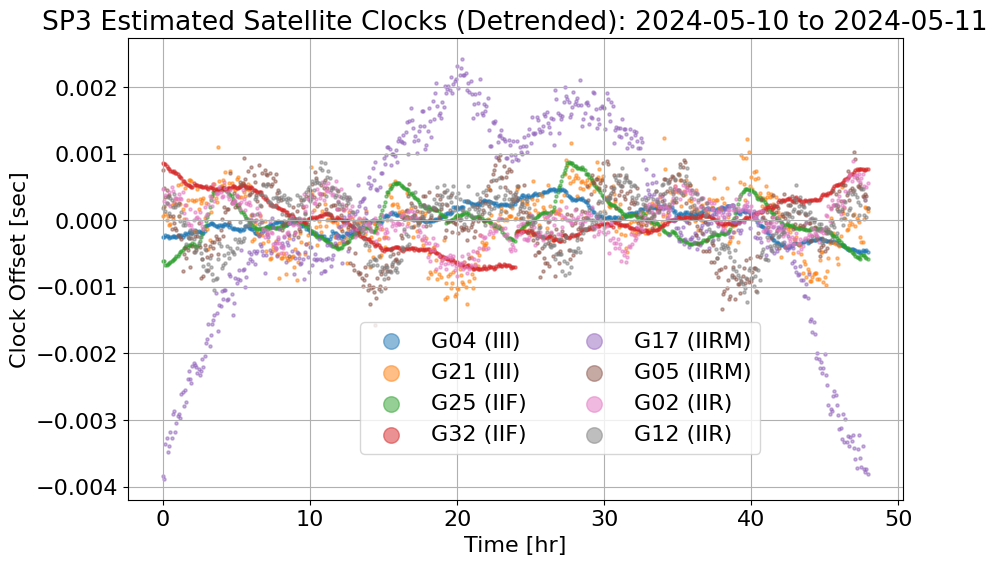

In [5]:
# Plot satellite clocks
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import scipy.signal
import gnss_tools.misc.nan_utils as nan_utils


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_epoch_offset_gpst = sim_start_gpst
plot_times = sp3_arrays.epochs - plot_epoch_offset_gpst

prn_examples = {
    "III": [4, 21],
    "IIF": [25, 32],
    "IIRM": [17, 5],
    "IIR": [2, 12]
}
# for sat_id, sat_clock in sp3_arrays.clock.items():
#     if not sat_id.startswith("G"):
#         continue
#     prn = int(sat_id[1:])
#     block_key = None
#     for key, prn_list in prn_examples.items():
#         if prn in prn_list:
#             block_key = key
#             break
#     if block_key is None:
#         continue
for block_key, prn_list in prn_examples.items():
    for prn in prn_list:
        sat_id = f"G{prn:02}"
        sat_clock = sp3_arrays.clock.get(sat_id, None)
        if sat_clock is None:
            continue
        # ax.plot(plot_times / 3600.0, nan_utils.nan_scipy_detrend(sat_clock), marker=".", markersize=5, alpha=.1, label=f"G{prn:02} ({block_key})")
        ax.scatter(plot_times / 3600.0, nan_utils.nan_scipy_detrend(sat_clock), s=5, alpha=.5, label=f"G{prn:02} ({block_key})")
ax.grid()
ax.legend(loc=(.3, .1), ncol=2, markerscale=5)
ax.set_xlabel("Time [hr]")
ax.set_ylabel("Clock Offset [sec]")
ax.set_title(f"SP3 Estimated Satellite Clocks (Detrended): {sim_start_dt:%Y-%m-%d} to {sim_end_dt:%Y-%m-%d}")

In [ ]:
6 * 20e-3 + 4 * 1e-3 + 501.9 / 1.023e6

In [ ]:
import numpy as np
num_bits = 10
bits = np.round(np.random.rand(num_bits))
print(bits)
# prints: [0. 1. 0. 1. 0. 1. 1. 0. 0. 1.]

In [ ]:
def encode(bits):
    pass

frame_bits = bits
symbols = encode(frame_bits)

Text(0.5, 0, 'Frequency [Hz]')

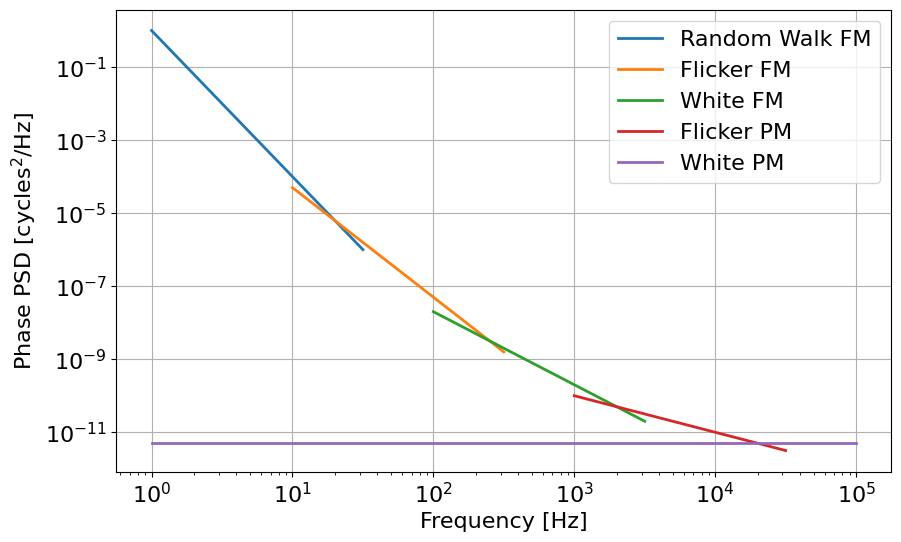

In [35]:
# remake phase noise PSD plot
import numpy as np
noise_power_coeffs = {
    -2: ("Random Walk FM", (0, 1.5), 1),
    -1: ("Flicker FM", (1, 2.5), 5e-2),
     0: ("White FM", (2, 3.5), 2e-4),
     1: ("Flicker PM", (3, 4.5), 1e-7),
     2: ("White PM", (0, 5.), 5e-12),
}
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for slope, (label, (start, stop), amp) in noise_power_coeffs.items():
    f = np.logspace(start, stop, 10)
    psd = amp * f**(slope - 2)
    ax.plot(f, psd, label=label, linewidth=2)
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylabel("Phase PSD [cycles$^2$/Hz]")
ax.set_xlabel("Frequency [Hz]")

In [45]:
noise_power_coeffs = {
    # -2: ("Random Walk FM", (0, 1.1), 1),
    # -1: ("Flicker FM", (1.1, 2.1), 5e-2),
    #  0: ("White FM", (2.1, 3.1), 2e-4),
    #  1: ("Flicker PM", (3.1, 4.1), 1e-7),
    #  2: ("White PM", (4, 10), 5e-12),
    # -2: ("Random Walk FM", (0, 1.1), 0),
    # -1: ("Flicker FM", (1.1, 2.1), 1e-2),
    #  0: ("White FM", (2.1, 3.1), 2e-4),
    #  1: ("Flicker PM", (3.1, 4.1), 1e-12),
    #  2: ("White PM", (4, 10), 1e-14),
    -2: ("Random Walk FM", (0, 1.1), 0),
    -1: ("Flicker FM", (1.1, 2.1), 5e-2),
     0: ("White FM", (2.1, 3.1), 2e-4),
     1: ("Flicker PM", (3.1, 4.1), 1e-8),
     2: ("White PM", (4, 10), 5e-13),
}
samp_rate = 2e6
samp_duration = 1.0
num_samples = int(samp_rate * samp_duration)
psd_freq = np.fft.fftfreq(num_samples, d=1/samp_rate)
time_arr = np.arange(num_samples) / samp_rate
phase_psd = np.zeros(num_samples)
for slope, (_, (start, stop), amp) in noise_power_coeffs.items():
    i0, i1 = np.searchsorted(psd_freq[:num_samples // 2], (10**start, 10**stop))
    phase_psd[i0:i1] += amp * psd_freq[i0:i1]**(slope - 2)
phase_psd[num_samples // 2 + 1:] = phase_psd[1:num_samples // 2][::-1]

freq_noise = (np.random.randn(num_samples) + 1j * np.random.randn(num_samples)) / np.sqrt(2)
shaped_noise_fft = freq_noise * np.sqrt(phase_psd * samp_rate)
shaped_noise = np.fft.ifft(shaped_noise_fft).imag

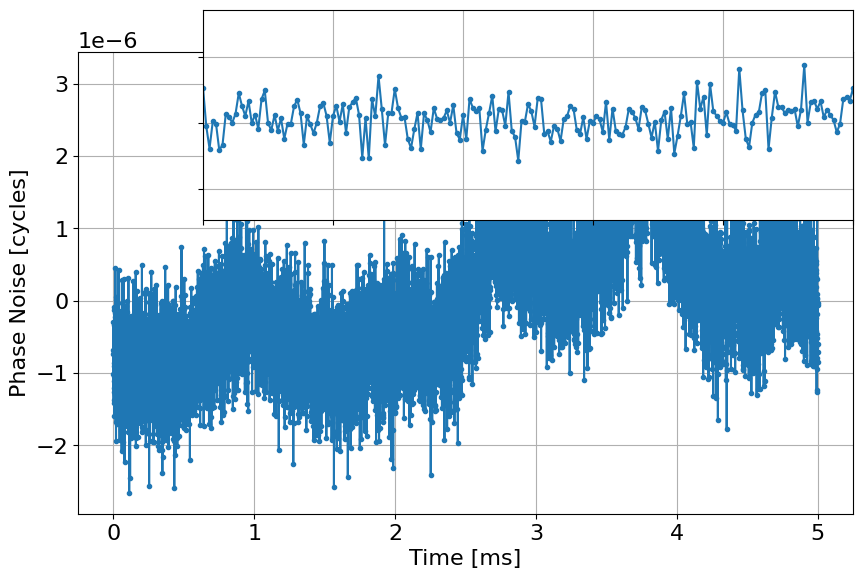

In [49]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
num_plot = 10000
ax.plot(time_arr[:num_plot] * 1e3, (shaped_noise[:num_plot] - np.mean(shaped_noise[:num_plot])).real, marker='.')
# ax.plot(time_arr[:num_plot] * 1e3, freq_noise[:num_plot].real * 2e-6, marker='.', alpha=.1)
# add inset axes and plot from 2 to 3 ms
axinset = fig.add_axes([0.25, 0.6, 0.65, 0.35])
axinset.plot(time_arr[:num_plot] * 1e3, (shaped_noise[:num_plot] - np.mean(shaped_noise[:num_plot])).real, marker='.')
# axinset.plot(time_arr[:num_plot] * 1e3, freq_noise[:num_plot].real * 2e-6, marker='.', alpha=.1)
axinset.set_xlim(2.5, 2.6)
axinset.grid()
axinset.set_yticklabels([])
axinset.set_xticklabels([])
# handles = [plt.Line2D([0], [0], color=color) for color in ['blue', 'orange']]
# labels = ['Shaped Phase Noise', 'White Noise']
# ax.legend(handles, labels, loc='lower left')
ax.grid()
ax.set_ylabel("Phase Noise [cycles]")
ax.set_xlabel("Time [ms]")
plt.show()

In [ ]:
def generate_psd(psd_freq, psd_noise_coeffs):
    pass

psd_noise_power_coeffs = {
    -2: ("Random Walk FM", (0, 1.1), 1),
    -1: ("Flicker FM", (1.1, 2.1), 5e-2),
     0: ("White FM", (2.1, 3.1), 2e-4),
     1: ("Flicker PM", (3.1, 4.1), 1e-7),
     2: ("White PM", (4, 10), 1e-12),
}
psd_args = 1

samp_rate = 2e6
samp_duration = 1.0
num_samples = int(samp_rate * samp_duration)
psd_freq = np.fft.fftfreq(num_samples, d=1/samp_rate)
psd_args = 1  # PSD generation arguments
phase_psd = generate_psd(psd_freq, psd_args)

freq_noise = (np.random.randn(num_samples) + 1j * np.random.randn(num_samples)) / np.sqrt(2)
shaped_noise_fft = freq_noise * np.sqrt(phase_psd * samp_rate)
shaped_noise = np.fft.ifft(shaped_noise_fft).imag

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(psd_freq[:num_samples // 2], phase_psd[:num_samples // 2], linewidth=2)
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
# plot the satellite orbits
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
for block_key, prn_list in prn_examples.items():
    for prn in prn_list:
        sat_id = f"G{prn:02}"
        sat_pos_ecf = sp3_arrays.position.get(sat_id, None)
        if sat_pos_ecf is None:
            continue
        ax.plot(sat_pos_ecf[:, 0] / 1e3, sat_pos_ecf[:, 1] / 1e3, sat_pos_ecf[:, 2] / 1e3, label=f"G{prn:02} ({block_key})")
        # sat_pos_eci = coords.ecf2eci(sp3_arrays.epochs, sat_pos)
        # ax.plot(sat_pos_eci[:, 0] / 1e3, sat_pos_eci[:, 1] / 1e3, sat_pos_eci[:, 2] / 1e3, label=f"G{prn:02} ({block_key})")

In [ ]:
import pyvista as pv

In [ ]:
# Light of the Sun.
light = pv.Light(shadow_attenuation=0.7)
light.set_direction_angle(30, -20)

# Load planets
earth = pv.examples.planets.load_earth(radius=6378.1)
earth_texture = pv.examples.load_globe_texture()
earth.translate((0.0, 0.0, 0.0), inplace=True)
earth.rotate_y(23.5, inplace=True)  # Tilt Earth's axis

# Add planets to Plotter.
pl = pv.Plotter(lighting="none", notebook=True, window_size=(800, 600))
cubemap = pv.examples.download_cubemap_space_4k()
_ = pl.add_actor(cubemap.to_skybox())
pl.set_environment_texture(cubemap, is_srgb=True, resample=1 / 64)
pl.add_light(light)
pl.add_mesh(earth, texture=earth_texture, smooth_shading=True)

sat_id = "G01"
sat_pos_ecf_km = sp3_arrays.position[sat_id][:200] / 1e3
spline = pv.Spline(sat_pos_ecf_km)
pl.add_mesh(spline, scalars="arc_length", render_lines_as_tubes=False, line_width=5)

pl.show()

In [ ]:
import numpy as np
np.set_printoptions(precision=5, suppress=False)

In [ ]:
day_start_gpst = ...  # GPS seconds at start of day, where we start geometry simulation

samp_rate = 5e6  # 5 MHz
sim_duration = 2.0  # seconds
time_arr = np.arange(0, sim_duration, 1.0 / samp_rate)
sim_start_time_gpst = day_start_gpst + 12 * 3600 - 15  # 12:00:00 GPST minus 15 seconds
# time_arr = [0.e+00, 2.e-07, 4.e-07, ... ]

In [ ]:
# interpolate propagation delay at each time in time_arr
tau = ...  # propagation delay (seconds)
omega = 2 * np.pi * 1.57542e9  # L1 frequency in radians per second
phi = -omega * tau
carrier_samples = np.cos(phi)

In [ ]:
phi = -omega * tau  # same as before
carrier_samples = np.exp(1j * phi)

In [ ]:
# MATLAB code sampling

eta_chips = mod(floor(time_arr * code_rate_cps), code_length)

In [ ]:
# example code sequence
code_seq = [1, -1, 1, 1, -1, 1, -1, -1, 1, -1]
code_length = len(code_seq)
code_rate_cps = 1.023e6  # chips per second

eta_chips = (time_arr * code_rate_cps).astype(int) % code_length
code_samples = code_seq[eta_chips]  

tau = ...  # (interpolated) propagation delay at each time in time_arr, in seconds
eta = time_arr - tau
eta_chips = (eta * code_rate_cps).astype(int) % code_length
code_samples = code_seq[eta_chips]

In [ ]:
data_seq_length = 500
data_bits = np.round(np.random.rand(data_seq_length))
data_symbol_seq = 1 - 2 * data_bits.astype(int)  # BPSK: 0 -> +1, 1 -> -1
data_rate_sps = 50  # symbols (bits) per second

tau = ...  # (interpolated) propagation delay at each time in time_arr, in seconds
eta = time_arr - tau
eta_symbols = (eta * data_rate_sps).astype(int) % data_seq_length
data_samples = data_symbol_seq[eta_symbols]

In [ ]:
boltzmann_constant = 1.380649e-23  # J/K
eff_noise_temperature = 535  # K
bandwidth_hz = samp_rate
noise_power = boltzmann_constant * eff_noise_temperature * bandwidth_hz

In [ ]:
rx_cn0 = 45  # dB-Hz
signal_power = noise_power * 10**(rx_cn0 / 10)
signal_amp = np.sqrt(2 * signal_power)

In [ ]:
carrier_samples = ...  # from previous code

signal_samples_nf = (
    0.5 * signal_amp * code_samples
    * data_samples * carrier_samples
)

In [ ]:
num_samples = ...  # number of samples
white_noise = (np.random.randn(num_samples) + 1j * np.random.randn(num_samples)) / np.sqrt(2)
noise_samples = np.sqrt(noise_power) * white_noise

In [ ]:
signal_samples = signal_samples_nf + noise_samples
num_quant_bits = 4
num_quant_levels = 2**num_quant_bits
# assume even quantization levels between +/- max_signal_amp
max_signal_amp = np.max(np.abs(signal_samples))
quant_sig_samples = np.round(signal_samples / max_signal_amp * (num_quant_levels / 2))